# Assessing the train error using Neural Networks

In [ ]:
#Code borrowed from M. Hjorth-Jensen

In [1]:
#Schedulers for tuning the learning rate:
import autograd.numpy as np

class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass

class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass

class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass

class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None

class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None

class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0

class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

In [2]:
#Cost Function: MSE
import autograd.numpy as np

def CostOLS(target):
    
    def func(X):
        return (1.0 / target.shape[0]) * np.sum((target - X) ** 2)

    return func

In [3]:
#Activation functions
import autograd.numpy as np
from autograd import elementwise_grad

def identity(X):
    return X


def sigmoid(X):
    try:
        return 1.0 / (1 + np.exp(-X))
    except FloatingPointError:
        return np.where(X > np.zeros(X.shape), np.ones(X.shape), np.zeros(X.shape))


def softmax(X):
    X = X - np.max(X, axis=-1, keepdims=True)
    delta = 10e-10
    return np.exp(X) / (np.sum(np.exp(X), axis=-1, keepdims=True) + delta)


def RELU(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))


def LRELU(X):
    delta = 10e-4
    return np.where(X > np.zeros(X.shape), X, delta * X)


def derivate(func):
    if func.__name__ == "RELU":

        def func(X):
            return np.where(X > 0, 1, 0)

        return func

    elif func.__name__ == "LRELU":

        def func(X):
            delta = 10e-4
            return np.where(X > 0, 1, delta)

        return func

    else:
        return elementwise_grad(func)

In [4]:
import math
import autograd.numpy as np
import sys
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy, copy
from typing import Tuple, Callable
from sklearn.utils import resample

class FFNN:
    """
    Description:
    ------------
        Feed Forward Neural Network with interface enabling flexible design of a
        nerual networks architecture and the specification of activation function
        in the hidden layers and output layer respectively. This model can be used
        for both regression and classification problems, depending on the output function.

    Attributes:
    ------------
        I   dimensions (tuple[int]): A list of positive integers, which specifies the
            number of nodes in each of the networks layers. The first integer in the array
            defines the number of nodes in the input layer, the second integer defines number
            of nodes in the first hidden layer and so on until the last number, which
            specifies the number of nodes in the output layer.
        II  hidden_func (Callable): The activation function for the hidden layers
        III output_func (Callable): The activation function for the output layer
        IV  cost_func (Callable): Our cost function
        V   seed (int): Sets random seed, makes results reproducible
    """

    def __init__(
        self,
        dimensions: tuple[int],
        hidden_func: Callable = sigmoid,
        output_func: Callable = lambda x: x,
        cost_func: Callable = CostOLS,
        seed: int = None,
    ):
        self.dimensions = dimensions
        self.hidden_func = hidden_func
        self.output_func = output_func
        self.cost_func = cost_func
        self.seed = seed
        self.weights = list()
        self.schedulers_weight = list()
        self.schedulers_bias = list()
        self.a_matrices = list()
        self.z_matrices = list()
        self.classification = None

        self.reset_weights()
        self._set_classification()

    def fit(
        self,
        X: np.ndarray,
        t: np.ndarray,
        scheduler: Scheduler,
        batches: int = 1,
        epochs: int = 100,
        lam: float = 0,
        X_val: np.ndarray = None,
        t_val: np.ndarray = None,
    ):
        """
        Description:
        ------------
            This function performs the training the neural network by performing the feedforward and backpropagation
            algorithm to update the networks weights.

        Parameters:
        ------------
            I    X (np.ndarray) : training data
            II   t (np.ndarray) : target data
            III  scheduler (Scheduler) : specified scheduler (algorithm for optimization of gradient descent)
            IV   scheduler_args (list[int]) : list of all arguments necessary for scheduler

        Optional Parameters:
        ------------
            V    batches (int) : number of batches the datasets are split into, default equal to 1
            VI   epochs (int) : number of iterations used to train the network, default equal to 100
            VII  lam (float) : regularization hyperparameter lambda
            VIII X_val (np.ndarray) : validation set
            IX   t_val (np.ndarray) : validation target set

        Returns:
        ------------
            I   scores (dict) : A dictionary containing the performance metrics of the model.
                The number of the metrics depends on the parameters passed to the fit-function.

        """

        # setup 
        if self.seed is not None:
            np.random.seed(self.seed)

        val_set = False
        if X_val is not None and t_val is not None:
            val_set = True

        # creating arrays for score metrics
        train_errors = np.empty(epochs)
        train_errors.fill(np.nan)
        val_errors = np.empty(epochs)
        val_errors.fill(np.nan)

        train_accs = np.empty(epochs)
        train_accs.fill(np.nan)
        val_accs = np.empty(epochs)
        val_accs.fill(np.nan)

        self.schedulers_weight = list()
        self.schedulers_bias = list()

        batch_size = X.shape[0] // batches

        X, t = resample(X, t)

        # this function returns a function valued only at X
        cost_function_train = self.cost_func(t)
        if val_set:
            cost_function_val = self.cost_func(t_val)

        # create schedulers for each weight matrix
        for i in range(len(self.weights)):
            self.schedulers_weight.append(copy(scheduler))
            self.schedulers_bias.append(copy(scheduler))

        print(f"{scheduler.__class__.__name__}: Eta={scheduler.eta}, Lambda={lam}")

        try:
            for e in range(epochs):
                for i in range(batches):
                    # allows for minibatch gradient descent
                    if i == batches - 1:
                        # If the for loop has reached the last batch, take all thats left
                        X_batch = X[i * batch_size :, :]
                        t_batch = t[i * batch_size :, :]
                    else:
                        X_batch = X[i * batch_size : (i + 1) * batch_size, :]
                        t_batch = t[i * batch_size : (i + 1) * batch_size, :]

                    self._feedforward(X_batch)
                    self._backpropagate(X_batch, t_batch, lam)

                # reset schedulers for each epoch (some schedulers pass in this call)
                for scheduler in self.schedulers_weight:
                    scheduler.reset()

                for scheduler in self.schedulers_bias:
                    scheduler.reset()

                # computing performance metrics
                pred_train = self.predict(X)
                train_error = cost_function_train(pred_train)

                train_errors[e] = train_error
                if val_set:
                    
                    pred_val = self.predict(X_val)
                    val_error = cost_function_val(pred_val)
                    val_errors[e] = val_error

                if self.classification:
                    train_acc = self._accuracy(self.predict(X), t)
                    train_accs[e] = train_acc
                    if val_set:
                        val_acc = self._accuracy(pred_val, t_val)
                        val_accs[e] = val_acc

                # printing progress bar
                progression = e / epochs
                print_length = self._progress_bar(
                    progression,
                    train_error=train_errors[e],
                    train_acc=train_accs[e],
                    val_error=val_errors[e],
                    val_acc=val_accs[e],
                )
        except KeyboardInterrupt:
            # allows for stopping training at any point and seeing the result
            pass

        # visualization of training progression (similiar to tensorflow progression bar)
        sys.stdout.write("\r" + " " * print_length)
        sys.stdout.flush()
        self._progress_bar(
            1,
            train_error=train_errors[e],
            train_acc=train_accs[e],
            val_error=val_errors[e],
            val_acc=val_accs[e],
        )
        sys.stdout.write("")

        # return performance metrics for the entire run
        scores = dict()

        scores["train_errors"] = train_errors

        if val_set:
            scores["val_errors"] = val_errors

        if self.classification:
            scores["train_accs"] = train_accs

            if val_set:
                scores["val_accs"] = val_accs

        return scores

    def predict(self, X: np.ndarray, *, threshold=0.5):
        """
         Description:
         ------------
             Performs prediction after training of the network has been finished.

         Parameters:
        ------------
             I   X (np.ndarray): The design matrix, with n rows of p features each

         Optional Parameters:
         ------------
             II  threshold (float) : sets minimal value for a prediction to be predicted as the positive class
                 in classification problems

         Returns:
         ------------
             I   z (np.ndarray): A prediction vector (row) for each row in our design matrix
                 This vector is thresholded if regression=False, meaning that classification results
                 in a vector of 1s and 0s, while regressions in an array of decimal numbers

        """

        predict = self._feedforward(X)

        if self.classification:
            return np.where(predict > threshold, 1, 0)
        else:
            return predict

    def reset_weights(self):
        """
        Description:
        ------------
            Resets/Reinitializes the weights in order to train the network for a new problem.

        """
        if self.seed is not None:
            np.random.seed(self.seed)

        self.weights = list()
        for i in range(len(self.dimensions) - 1):
            weight_array = np.random.randn(
                self.dimensions[i] + 1, self.dimensions[i + 1]
            )
            weight_array[0, :] = np.random.randn(self.dimensions[i + 1]) * 0.01

            self.weights.append(weight_array)

    def _feedforward(self, X: np.ndarray):
        """
        Description:
        ------------
            Calculates the activation of each layer starting at the input and ending at the output.
            Each following activation is calculated from a weighted sum of each of the preceeding
            activations (except in the case of the input layer).

        Parameters:
        ------------
            I   X (np.ndarray): The design matrix, with n rows of p features each

        Returns:
        ------------
            I   z (np.ndarray): A prediction vector (row) for each row in our design matrix
        """

        # reset matrices
        self.a_matrices = list()
        self.z_matrices = list()

        # if X is just a vector, make it into a matrix
        if len(X.shape) == 1:
            X = X.reshape((1, X.shape[0]))

        # Add a coloumn of zeros as the first coloumn of the design matrix, in order
        # to add bias to our data
        bias = np.ones((X.shape[0], 1)) * 0.01
        X = np.hstack([bias, X])

        # a^0, the nodes in the input layer (one a^0 for each row in X - where the
        # exponent indicates layer number).
        a = X
        self.a_matrices.append(a)
        self.z_matrices.append(a)

        # The feed forward algorithm
        for i in range(len(self.weights)):
            if i < len(self.weights) - 1:
                z = a @ self.weights[i]
                self.z_matrices.append(z)
                a = self.hidden_func(z)
                # bias column again added to the data here
                bias = np.ones((a.shape[0], 1)) * 0.01
                a = np.hstack([bias, a])
                self.a_matrices.append(a)
            else:
                try:
                    # a^L, the nodes in our output layers
                    z = a @ self.weights[i]
                    a = self.output_func(z)
                    self.a_matrices.append(a)
                    self.z_matrices.append(z)
                except Exception as OverflowError:
                    print(
                        "OverflowError in fit() in FFNN\nHOW TO DEBUG ERROR: Consider lowering your learning rate or scheduler specific parameters such as momentum, or check if your input values need scaling"
                    )

        # this will be a^L
        return a

    def _backpropagate(self, X: np.ndarray, t: np.ndarray, lam: float):
        """
        Description:
        ------------
            Performs the backpropagation algorithm. In other words, this method
            calculates the gradient of all the layers starting at the
            output layer, and moving from right to left accumulates the gradient until
            the input layer is reached. Each layers respective weights are updated while
            the algorithm propagates backwards from the output layer (auto-differentation in reverse mode).

        Parameters:
        ------------
            I   X (np.ndarray): The design matrix, with n rows of p features each.
            II  t (np.ndarray): The target vector, with n rows of p targets.
            III lam (float32): regularization parameter used to punish the weights in case of overfitting

        Returns:
        ------------
            No return value.

        """
        out_derivative = derivate(self.output_func)
        hidden_derivative = derivate(self.hidden_func)

        for i in range(len(self.weights) - 1, -1, -1):
            # delta terms for output
            if i == len(self.weights) - 1:
                # for multi-class classification
                if (
                    self.output_func.__name__ == "softmax"
                ):
                    delta_matrix = self.a_matrices[i + 1] - t
                # for binary classification
                else:
                    cost_func_derivative = grad(self.cost_func(t))
                    delta_matrix = out_derivative(
                        self.z_matrices[i + 1]
                    ) * cost_func_derivative(self.a_matrices[i + 1])

            # delta terms for hidden layer
            else:
                delta_matrix = (
                    self.weights[i + 1][1:, :] @ delta_matrix.T
                ).T * hidden_derivative(self.z_matrices[i + 1])

            # calculate gradient
            gradient_weights = self.a_matrices[i][:, 1:].T @ delta_matrix
            gradient_bias = np.sum(delta_matrix, axis=0).reshape(
                1, delta_matrix.shape[1]
            )

            # regularization term
            gradient_weights += self.weights[i][1:, :] * lam

            # use scheduler
            update_matrix = np.vstack(
                [
                    self.schedulers_bias[i].update_change(gradient_bias),
                    self.schedulers_weight[i].update_change(gradient_weights),
                ]
            )

            # update weights and bias
            self.weights[i] -= update_matrix

    def _accuracy(self, prediction: np.ndarray, target: np.ndarray):
        """
        Description:
        ------------
            Calculates accuracy of given prediction to target

        Parameters:
        ------------
            I   prediction (np.ndarray): vector of predicitons output network
                (1s and 0s in case of classification, and real numbers in case of regression)
            II  target (np.ndarray): vector of true values (What the network ideally should predict)

        Returns:
        ------------
            A floating point number representing the percentage of correctly classified instances.
        """
        assert prediction.size == target.size
        return np.average((target == prediction))
    
    def _set_classification(self):
        """
        Description:
        ------------
            Decides if FFNN acts as classifier (True) og regressor (False),
            sets self.classification during init()
        """
        self.classification = False
        if (
            self.cost_func.__name__ == "CostLogReg"
            or self.cost_func.__name__ == "CostCrossEntropy"
        ):
            self.classification = True

    def _progress_bar(self, progression, **kwargs):
        """
        Description:
        ------------
            Displays progress of training
        """
        print_length = 40
        num_equals = int(progression * print_length)
        num_not = print_length - num_equals
        arrow = ">" if num_equals > 0 else ""
        bar = "[" + "=" * (num_equals - 1) + arrow + "-" * num_not + "]"
        perc_print = self._format(progression * 100, decimals=5)
        line = f"  {bar} {perc_print}% "

        for key in kwargs:
            if not np.isnan(kwargs[key]):
                value = self._format(kwargs[key], decimals=4)
                line += f"| {key}: {value} "
        sys.stdout.write("\r" + line)
        sys.stdout.flush()
        return len(line)

    def _format(self, value, decimals=4):
        """
        Description:
        ------------
            Formats decimal numbers for progress bar
        """
        if value > 0:
            v = value
        elif value < 0:
            v = -10 * value
        else:
            v = 1
        n = 1 + math.floor(math.log10(v))
        if n >= decimals - 1:
            return str(round(value))
        return f"{value:.{decimals-n-1}f}"




227


/tmp/ipykernel_5862/1993392393.py:90: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(ltd, final_sw_in*10**-15, 'o', marker=".", markersize=2, label='time-, zonally- averaged in sw')


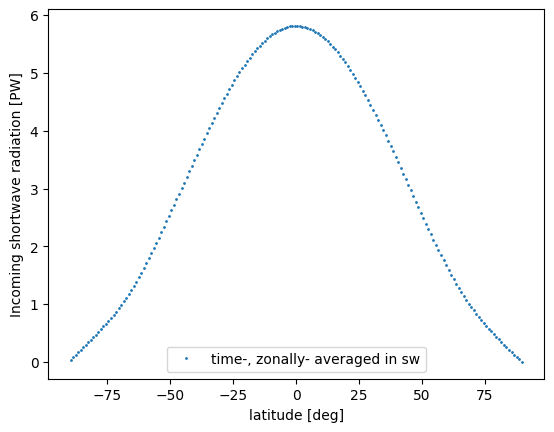

In [5]:
#Importing various packages
import os
import netCDF4 #(to open .nc files, numpy and netCDF libraries had to be installed first)
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
from scipy import integrate

#Defining the dataset. We want to calculate the meridional heat transport as: total transport= incoming shortwave radiation - (outgoing shortwave + outgoing longwave)

#Zonal and Time- average for the incoming shortwave radiation

#moving into the right folder:

os.chdir('/home/chrikap/Desktop/NASA CERES EBAF_all_latitudes/incoming solar')

#open all of the incoming sw rad. datasets (the ones that start with 'data_312b_Lot1_ceres-ebaf_tcdr_v4.1_solar_mon'):

filenames=glob('data_312b_Lot1_ceres-ebaf_tcdr_v4.1_solar_mon*.nc') 
print(np.size(filenames))                 #just to know how many datasets we have

sw = []                                   #list for the zonally-averaged values, calculated by integration
sw_mean = []                              #list for the zonally-averaged values, calculated by taking the mean along longtitude

for f in filenames:
    f = xr.open_dataset(f)
    
    lati = f.variables['lat']             # extracting latitude values
    lati = lati.values
    
    lon = f.variables['lon']              # extracting longitude values
    lon = lon.values
    #print(lon.shape)
    
    sw_in = f.variables['solar_mon']      # extracting incoming sw rad. values
    sw_in = sw_in.values
    #print(sw_in.shape)
    
    #zonal average for 1 month, using the trapezoid integration rule:
    
    zonal_sw_in = (integrate.cumulative_trapezoid(sw_in, x=lon, dx=1.0, axis=2, initial=0))/2*np.pi 
    zonal_sw_in = zonal_sw_in[:, :, 2]    # extracting the last column of the 3D-array
    #print(zonal_sw_in.shape)
    #print(zonal_sw_in)
    
    #zonal average for 1 month, taking the mean along longtitude:
    
    zonal_sw_in_mean = sw_in.mean(axis=2)
        
    #getting rid of the 'time' dimention of each month:
    
    time_sw_in = zonal_sw_in.mean(axis=0)

    time_sw_in_mean = zonal_sw_in_mean.mean(axis=0)
    
    #adding the final zonally- averaged value for each month in the list:
    
    sw.append(time_sw_in)
    
    sw_mean.append(time_sw_in_mean)
    
#turning the final lists into arrays:

sw = np.array(sw)

sw_mean = np.array(sw_mean)

#at this point, these arrays, contain all of the arrays with the zonally-averaged values vs. latitude, for each month.
#so, we average over all of the months:

sw_in_tot = sw.mean(axis=0)              #the total incoming sw rad. zonally averaged uding the trapezoid rule      
sw_in_tot_mean = sw_mean.mean(axis=0)    #the total incoming sw rad. zonally averaged by taking the mean

ltd=lati                                 #the latitude values to plot against

#now, we have expressed the heat transport in [W/m**2]. Yet, we need it in [PW], which means we have to multiply the value of every latitude band with the area of the band itself. So, let's go!

final_sw_in = np.zeros(180)

for i in range(180-1):
    R = 6371000                                #the radius of the Earth in [m]
    h1 = R*np.sin(ltd[i]*np.pi/180)            #the height of the first latitude circle
    h2 = R*np.sin(ltd[i+1]*np.pi/180)          #the height of the second latitude circle
    h = h2-h1                                  #the height of the band
    band_area = 2*np.pi*R*h                    #the area of the band
    final_sw_in[i] = band_area*sw_in_tot[i]    #the total heat flux for each latitude band

import matplotlib.pyplot as plt
plt.plot(ltd, final_sw_in*10**-15, 'o', marker=".", markersize=2, label='time-, zonally- averaged in sw')
#plt.plot(ltd, sw_in_tot_mean, label='time-, zonally- averaged in sw mean') #so, it's the same in shape but scaled
plt.xlabel('latitude [deg]')
plt.ylabel('Incoming shortwave radiation [PW]')
plt.legend()
plt.show()

265


/tmp/ipykernel_5862/4283149436.py:79: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(ltd, final_lw_out*10**-15, 'o', marker=".", markersize=2, label='time-, zonally- averaged out lw')


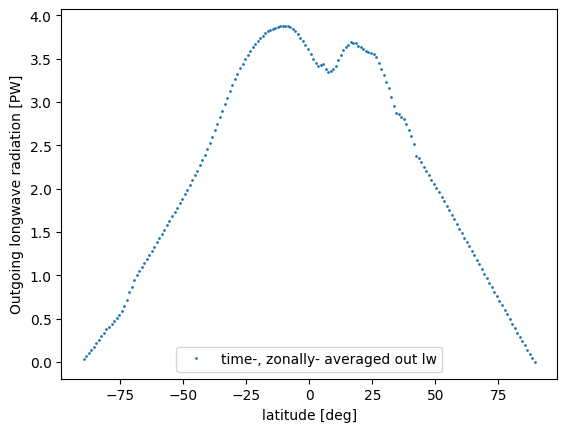

In [6]:
#Zonal and Time- average for the outgoing longwave radiation

#moving into the right folder:

os.chdir('/home/chrikap/Desktop/NASA CERES EBAF_all_latitudes/outgoing lw')

#open all of the outgoing lw rad. datasets:

filenames=glob('data_312b_Lot1_ceres-ebaf_tcdr_v4.1_toa_lw_all_mon*.nc') 
print(np.size(filenames))                      #just to know how many datasets we have

lw_out_list = []                               #list for the zonally-averaged values, calculated by integration
lw_out_mean_list = []                          #list for the zonally-averaged values, calculated by taking the mean along longtitude

for f in filenames:
    f = xr.open_dataset(f)
    
    lati = f.variables['lat']                 #extracting latitude values
    lati = lati.values
    
    lon = f.variables['lon']                  #extracting longitude values
    lon = lon.values
    #print(lon.shape)
    
    lw_out = f.variables['toa_lw_all_mon']    #extracting outgoing lw rad. values
    lw_out = lw_out.values
    #print(lw_out.shape)
    
    #zonal average for 1 month, using the trapezoid integration rule:
    
    zonal_lw_out = (integrate.cumulative_trapezoid(lw_out, x=lon, dx=1.0, axis=2, initial=0))/2*np.pi 
    zonal_lw_out = zonal_lw_out[:, :, 2]    # extracting the last column of the 3D-array
    #print(zonal_lw_out.shape)
    #print(zonal_lw_out)
    
    #zonal average for 1 month, taking the mean along longtitude:
    
    zonal_lw_out_mean = lw_out.mean(axis=2)
        
    #getting rid of the 'time' dimention of each month:
    
    time_lw_out = zonal_lw_out.mean(axis=0)

    time_lw_out_mean = zonal_lw_out_mean.mean(axis=0)
    
    #adding the final zonally- averaged value for each month in the list:
    
    lw_out_list.append(time_lw_out)
    
    lw_out_mean_list.append(time_lw_out_mean)
    
#turning the final lists into arrays:

lw_out = np.array(lw_out_list)

lw_out_mean = np.array(lw_out_mean_list)

#at this point, these arrays, contain all of the arrays with the zonally-averaged values vs. latitude, for each month.
#so, we average over all of the months:

lw_out_tot = lw_out.mean(axis=0)              #the total incoming sw rad. zonally averaged uding the trapezoid rule      
lw_out_tot_mean = lw_out_mean.mean(axis=0)    #the total incoming sw rad. zonally averaged by taking the mean

ltd=lati                                      #the latitude values to plot against

#now, we have expressed the heat transport in [W/m**2]. Yet, we need it in [PW], which means we have to multiply the value of every latitude band with the area of the band itself. So, let's go!

final_lw_out = np.zeros(180)

for i in range(180-1):
    R = 6371000                                #the radius of the Earth in [m]
    h1 = R*np.sin(ltd[i]*np.pi/180)            #the height of the first latitude circle
    h2 = R*np.sin(ltd[i+1]*np.pi/180)          #the height of the second latitude circle
    h = h2-h1                                  #the height of the band
    band_area = 2*np.pi*R*h     #the area of the band
    final_lw_out[i] = band_area*lw_out_tot[i]

import matplotlib.pyplot as plt
plt.plot(ltd, final_lw_out*10**-15, 'o', marker=".", markersize=2, label='time-, zonally- averaged out lw')
#plt.plot(ltd, lw_out_tot_mean, label='time-, zonally- averaged out lw mean') #so, it's the same in shape but scaled
plt.xlabel('latitude [deg]')
plt.ylabel('Outgoing longwave radiation [PW]')
plt.legend()
plt.show()

226


/tmp/ipykernel_5862/3081401252.py:79: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(ltd, final_sw_out*10**-15, 'o', marker=".", markersize=2, label='time-, zonally- averaged out sw')


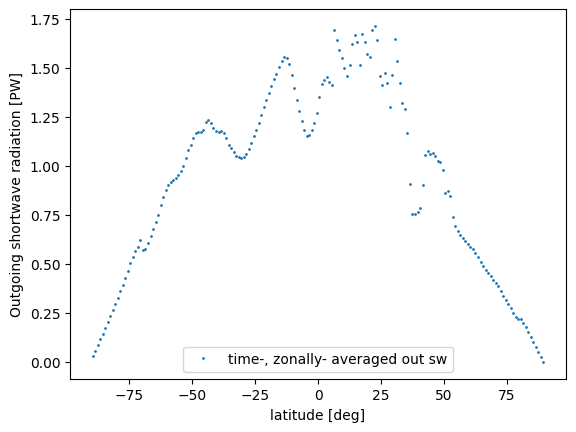

In [7]:
#Zonal and Time- average for the outgoing shortwave radiation

#moving into the right folder:

os.chdir('/home/chrikap/Desktop/NASA CERES EBAF_all_latitudes/outgoing sw')

#open all of the outgoing sw rad. datasets:

filenames=glob('data_312b_Lot1_ceres-ebaf_tcdr_v4.1_toa_sw_all_mon*.nc') 
print(np.size(filenames))                      #just to know how many datasets we have

sw_out_list = []                               #list for the zonally-averaged values, calculated by integration
sw_out_mean_list = []                          #list for the zonally-averaged values, calculated by taking the mean along longtitude

for f in filenames:
    f = xr.open_dataset(f)
    
    lati = f.variables['lat']                  #extracting latitude values
    lati = lati.values
    
    lon = f.variables['lon']                   #extracting longitude values
    lon = lon.values
    #print(lon.shape)
    
    sw_out = f.variables['toa_sw_all_mon']     #extracting outgoing sw rad. values
    sw_out = sw_out.values
    #print(sw_out.shape)
    
    #zonal average for 1 month, using the trapezoid integration rule:
    
    zonal_sw_out = (integrate.cumulative_trapezoid(sw_out, x=lon, dx=1.0, axis=2, initial=0))/2*np.pi 
    zonal_sw_out = zonal_sw_out[:, :, 2]    # extracting the last column of the 3D-array
    #print(zonal_sw_out.shape)
    #print(zonal_sw_out)
    
    #zonal average for 1 month, taking the mean along longtitude:
    
    zonal_sw_out_mean = sw_out.mean(axis=2)
        
    #getting rid of the 'time' dimention of each month:
    
    time_sw_out = zonal_sw_out.mean(axis=0)

    time_sw_out_mean = zonal_sw_out_mean.mean(axis=0)
    
    #adding the final zonally- averaged value for each month in the list:
    
    sw_out_list.append(time_sw_out)
    
    sw_out_mean_list.append(time_sw_out_mean)
    
#turning the final lists into arrays:

sw_out = np.array(sw_out_list)

sw_out_mean = np.array(sw_out_mean_list)

#at this point, these arrays, contain all of the arrays with the zonally-averaged values vs. latitude, for each month.
#so, we average over all of the months:

sw_out_tot = sw_out.mean(axis=0)              #the total incoming sw rad. zonally averaged uding the trapezoid rule      
sw_out_tot_mean = sw_out_mean.mean(axis=0)    #the total incoming sw rad. zonally averaged by taking the mean

ltd=lati                                      #the latitude values to plot against

#now, we have expressed the heat transport in [W/m**2]. Yet, we need it in [PW], which means we have to multiply the value of every latitude band with the area of the band itself. So, let's go!

final_sw_out = np.zeros(180)

for i in range(180-1):
    R = 6371000                                #the radius of the Earth in [m]
    h1 = R*np.sin(ltd[i]*np.pi/180)            #the height of the first latitude circle
    h2 = R*np.sin(ltd[i+1]*np.pi/180)          #the height of the second latitude circle
    h = h2-h1                                  #the height of the band
    band_area = 2*np.pi*R*h                    #the area of the band
    final_sw_out[i] = band_area*sw_out_tot[i]

import matplotlib.pyplot as plt
plt.plot(ltd, final_sw_out*10**-15, 'o', marker=".", markersize=2, label='time-, zonally- averaged out sw')
#plt.plot(ltd, sw_out_tot_mean, label='time-, zonally- averaged out sw mean') #so, it's the same in shape but scaled
plt.xlabel('latitude [deg]')
plt.ylabel('Outgoing shortwave radiation [PW]')
plt.legend()
plt.show()

/tmp/ipykernel_5862/3478583323.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(ltd, total*10**-15,'o', marker=".", markersize=2, label='time-, zonally- averaged h.t.')


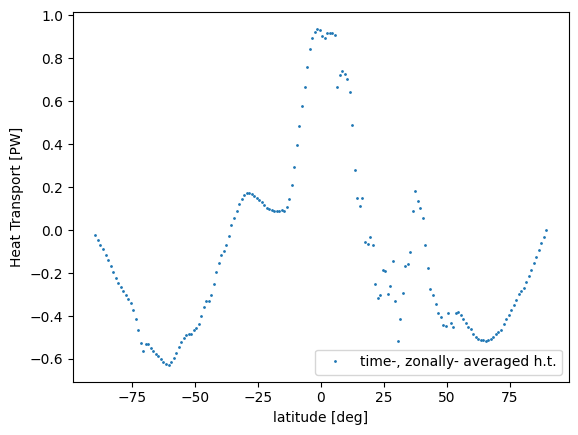

In [8]:
#Total heat transport, zonally- and time- averaged:

total= final_sw_in - (final_sw_out +final_lw_out)
#total_mean= sw_in_tot_mean - (sw_out_tot_mean + lw_out_tot_mean)

import matplotlib.pyplot as plt
plt.plot(ltd, total*10**-15,'o', marker=".", markersize=2, label='time-, zonally- averaged h.t.')
#plt.plot(ltd, total_mean, label='time-, zonally- averaged h.t. mean') #so, it's the same in shape but scaled
plt.xlabel('latitude [deg]')
plt.ylabel('Heat Transport [PW]')
plt.legend()
plt.show()

In [9]:
import autograd.numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

x=ltd.reshape(-1, 1)
target=(total*10**-15)
target=target.reshape(target.shape[0], 1)

#building the design matrix with powers of sin(x)

poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(np.sin(x))

X_train, X_test, t_train, t_test = train_test_split(X, target, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape, t_train.shape)

(144, 4) (144, 1)


In [11]:
#Model combinations:

input_nodes = X_train.shape[1]
output_nodes = 1

output_function=[identity, sigmoid, softmax, RELU, LRELU]
schedulers=[Constant(eta=1e-2), Momentum(eta=1e-2, momentum=10**-8), Adagrad(eta=1e-2), AdagradMomentum(eta=1e-2, momentum=10**-8), RMS_prop(eta=1e-2, rho=0.9), Adam(eta=1e-3, rho=0.9, rho2=0.099)]

train_e=np.zeros((len(output_function), len(schedulers)))

for output_func in output_function:
   
    linear_regression = FFNN((input_nodes, output_nodes), output_func=output_func, cost_func=CostOLS, seed=2023)
    
    linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights
    
    for scheduler in schedulers:
        
        scores = linear_regression.fit(X_train, t_train, scheduler, lam=0, epochs=1000)
        #train_e[w, p]=train_error
        #linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights
        #scores = linear_regression.fit(X_train, t_train, scheduler, lam=1e-5, epochs=1000)
        #print(i, j)

Constant: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.171  Momentum: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.168  Adagrad: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.167  AdagradMomentum: Eta=0.01, Lambda=0
  [====>-----------------------------------] 13.10% | train_error: 0.167  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  [=======================================>] 100.0% | train_error: 0.167 Adam: Eta=0.001, Lambda=0
  [=======================================>] 100.0% | train_error: 0.166  Constant: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.230  Momentum: Eta=0.01, Lambda=0
  [===================>--------------------] 51.60% | train_error: 0.213  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  [=======================================>] 100.0% | train_error: 0.177 AdagradMomentum: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.177  RMS_prop: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.177  Adam: Eta=0.001, Lambda=0
  [=======================================>] 100.0% | train_error: 0.177  Constant: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 1.35  Momentum: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 1.35  Adagrad: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 1.35  AdagradMomentum: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 1.35  RMS_prop: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 1.35  Adam: Eta=0.001, Lambda=0
  [=======================================>] 100.0% | train_error: 1.35 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  [=======================================>] 100.0% | train_error: 0.176 Momentum: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.176  Adagrad: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.176  AdagradMomentum: Eta=0.01, Lambda=0
  [================>-----------------------] 44.40% | train_error: 0.176  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  [=======================================>] 100.0% | train_error: 0.176 Adam: Eta=0.001, Lambda=0
  [=======================================>] 100.0% | train_error: 0.176  

In [12]:
train_error = [[0.171, 0.168, 0.176, 0.167, 0.167, 0.167], 
               [0.166, 0.230, 0.205, 0.177, 0.177, 0.177], 
               [0.177, 1.35, 1.35, 1.35, 1.35, 1.35], 
               [1.35, 0.176, 0.176, 0.176, 0.176, 0.176], 
               [0.176, 0.176, 0.176, 0.176, 0.176, 0.176]]

       0      1      2      3      4      5
0  0.171  0.168  0.176  0.167  0.167  0.167
1  0.166  0.230  0.205  0.177  0.177  0.177
2  0.177  1.350  1.350  1.350  1.350  1.350
3  1.350  0.176  0.176  0.176  0.176  0.176
4  0.176  0.176  0.176  0.176  0.176  0.176


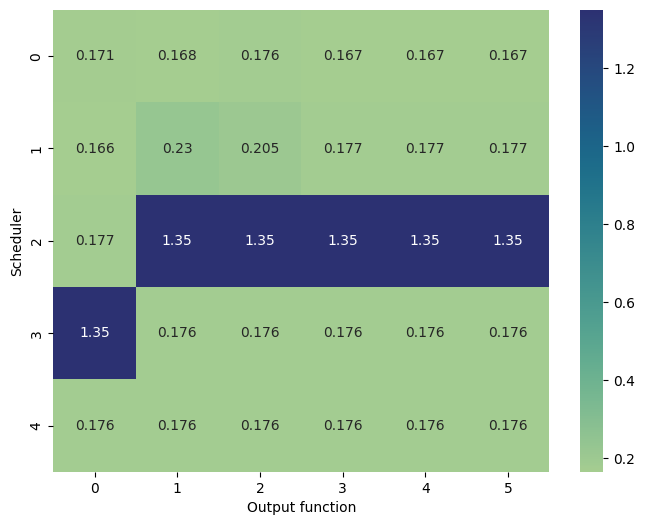

In [13]:
import pandas as pd
import seaborn as sns
#plot 3rd column
pd.DataFrame(train_error)


trainerror = pd.DataFrame(train_error)
print(trainerror)



plt.figure(figsize=(8,6))
sns.heatmap(data=trainerror, annot=True,  fmt=".3", cmap="crest")
plt.xlabel("Output function")
plt.ylabel("Scheduler")
plt.show()